In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import vgg19_bn

In [2]:
# 1.1 Load CIFAR10 dataset and show 9 augmented images with labels
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=9, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


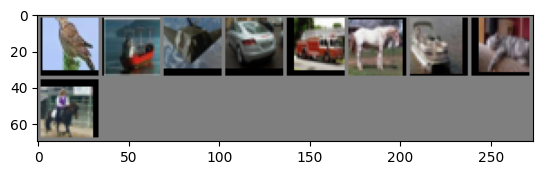

bird  ship  plane car   truck horse ship  cat   horse


In [3]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(9)))

In [4]:
!pip install torchsummary

In [9]:
import torchsummary
# 1.2 Load VGG19 with Batch Normalization model
model = vgg19_bn(pretrained=False, num_classes=10)  # Set num_classes to match CIFAR10
# Move model to device (GPU if available) before calling summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create a sample input tensor on the same device
input_data = torch.randn(1, 3, 32, 32).to(device)

torchsummary.summary(model, input_data.shape[1:]) # Pass input_size without batch dimension

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
# 1.3 Training and validating
num_epochs = 40
best_accuracy = 0.0
best_model = None

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100. * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(valloader)
    val_accuracy = 100. * correct / total

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model.state_dict()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/40, Train Loss: 1.8703, Train Accuracy: 29.95%, Val Loss: 1.4481, Val Accuracy: 45.32%
Epoch 2/40, Train Loss: 1.3722, Train Accuracy: 49.81%, Val Loss: 1.2321, Val Accuracy: 54.85%
Epoch 3/40, Train Loss: 1.1537, Train Accuracy: 59.35%, Val Loss: 1.0889, Val Accuracy: 61.57%
Epoch 4/40, Train Loss: 1.0133, Train Accuracy: 64.94%, Val Loss: 1.0211, Val Accuracy: 63.50%
Epoch 5/40, Train Loss: 0.9083, Train Accuracy: 68.85%, Val Loss: 0.9379, Val Accuracy: 68.43%
Epoch 6/40, Train Loss: 0.8261, Train Accuracy: 71.74%, Val Loss: 0.9082, Val Accuracy: 69.19%
Epoch 7/40, Train Loss: 0.7485, Train Accuracy: 74.75%, Val Loss: 0.8098, Val Accuracy: 72.68%
Epoch 8/40, Train Loss: 0.6981, Train Accuracy: 76.52%, Val Loss: 0.7406, Val Accuracy: 75.20%
Epoch 9/40, Train Loss: 0.6427, Train Accuracy: 78.65%, Val Loss: 0.7174, Val Accuracy: 75.86%
Epoch 10/40, Train Loss: 0.6069, Train Accuracy: 79.95%, Val Loss: 0.7402, Val Accuracy: 75.10%
Epoch 11/40, Train Loss: 0.5665, Train Accuracy: 

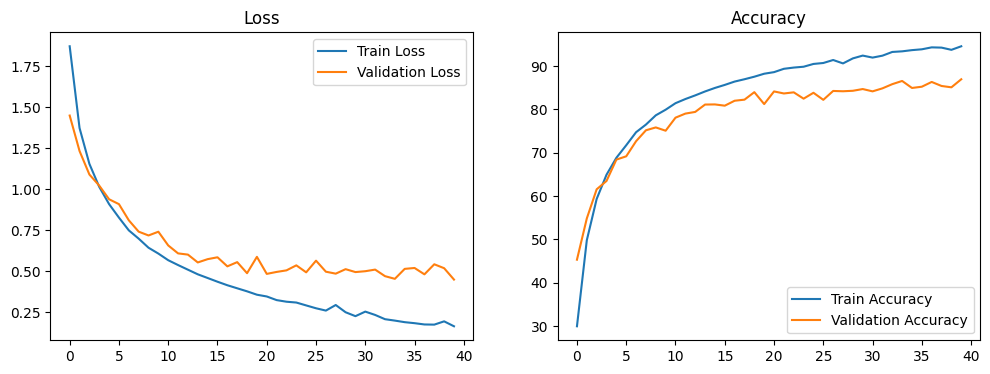

<All keys matched successfully>

In [12]:
# Plot training/validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Load the best model
model.load_state_dict(best_model)

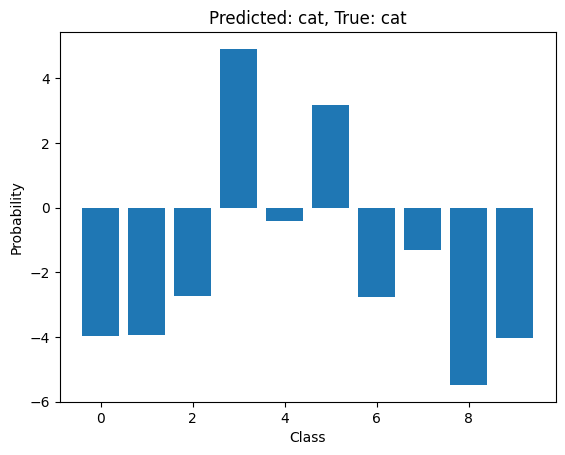

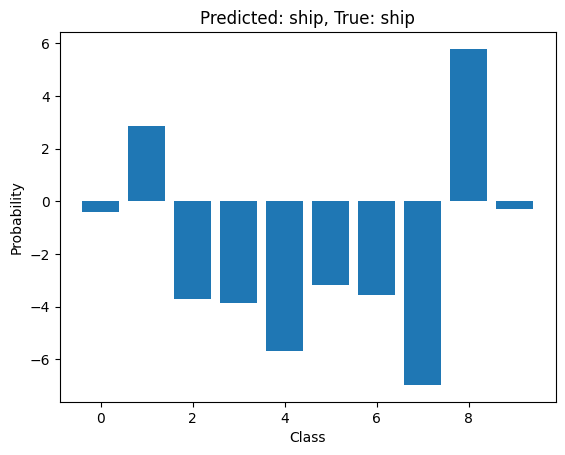

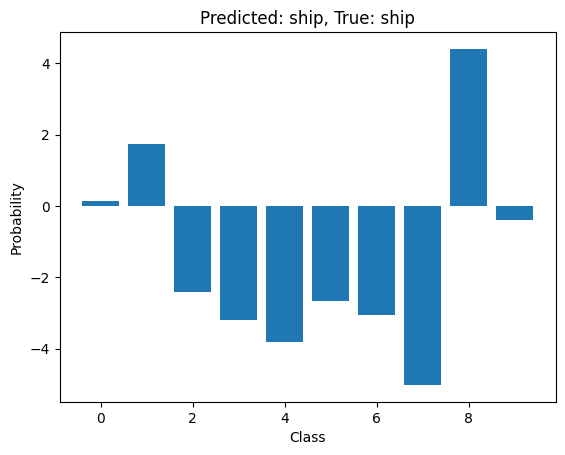

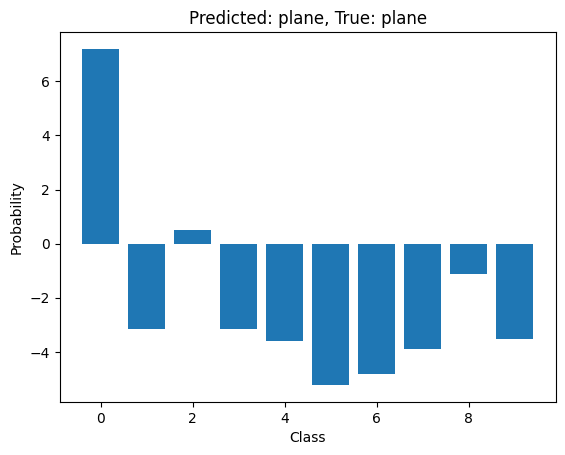

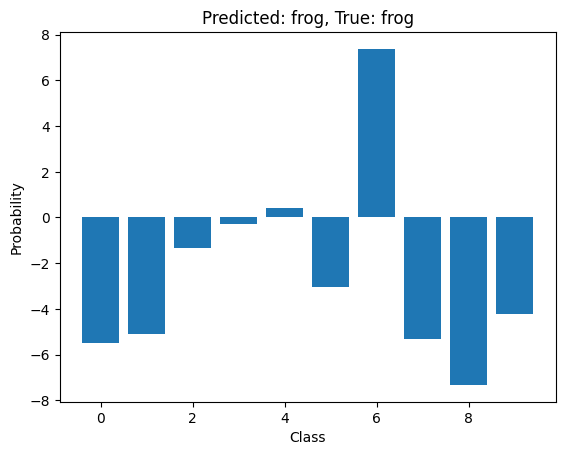

In [13]:
# 1.4 Run inference
model.eval()

# Get a batch of test data
dataiter = iter(valloader)
images, labels = next(dataiter)

# Move data to device
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = model(images)
predicted = torch.argmax(outputs, axis=1)

# Show predicted distributions and class labels
for i in range(5):
    plt.figure()
    plt.bar(range(10), outputs[i].cpu().detach().numpy())
    plt.title(f'Predicted: {classes[predicted[i]]}, True: {classes[labels[i]]}')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.show()


In [14]:
# Save the model
torch.save(model.state_dict(), 'vgg19.pth')